### 使用均方范数作为硬性限制
> * 通过限制参数值的选择范围来控制模型容量
>> * min $\ell(w,b)$ subject  to $||w||^2\leqslant\theta$
> * 通常不限制偏移b（限不限制都差不多）
> * 小的$\theta$意味着更强的正则项

### 使用均方范数作为柔性限制
> * 对每个$\theta$都可以找到$\lambda$使得之前的目标函数等价于下面：
>> * min $\ell(w,b)+\frac{\lambda}{2}||w||^2$，这里的$||w||$表示L2范式，即所有的w进行平方和相加开根号：$\sqrt {w_1^2+w_2^2+...+w_i^2}$
>> * 可以通过拉格朗日乘子来证明
> * 超参数$\lambda$控制了正则项的重要程度
>> * $\lambda = 0$：无作用
>> * $\lambda\rightarrow\infty，w^*\rightarrow0$
>> * <font color='red'>所以$\lambda$越大，对$w$限制性越强,取值范围越小</font>

### 参数更新法则
> * 计算梯度：
>> * $\frac{\partial}{\partial w}(\ell (w,b)+\frac{\lambda}{2}||w||^2) = \frac{\partial \ell(w,b)}{\partial w}+\lambda w$
> * 时间t更新参数：
>> * $w_{t+1} = (1-\eta \lambda)w_t-\eta \frac{\partial \ell(w_t,b_t)}{\partial w_t}$
>> * 通常$\eta \lambda < 1$, 在深度学习中通常叫做权重衰退

### 总结
> * 权重衰退通过L2正则项使得模型参数不会过大，从而控制模型复杂度
> * 正则项权重是控制模型复杂度的超参数

<font color='red'>注：不对b进行偏移，可能是因为b仅仅只是对图像做上下移动，并不会改变函数的复杂程度，而且可以直接通过改变w来拟合对b的偏移</font>

In [21]:
%matplotlib inline
import torch
from torch import nn
from d2l import limutorch as d2l

### 生成数据
> * $y = 0.05+\sum_{i=1}^{d}0.01x_i+\epsilon where \epsilon \sim N(0, 0.01^2)$

In [22]:
n_train, n_test, num_imputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_imputs,1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [23]:
"""初始化模型参数"""
def init_params():
  w = torch.normal(0, 1, size=(num_imputs, 1), requires_grad=True)
  b = torch.zeros(1, requires_grad=True)
  return [w, b]

In [24]:
"""定义L2范数惩罚"""
def l2_penalty(w):
  return torch.sum(w.pow(2)) / 2

In [25]:
"""定义训练代码实现"""
def train(lambd):
  w, b = init_params()
  net, loss = lambda X:d2l.linreg(X, w, b), d2l.squared_loss
  num_epochs , lr = 100, 0.003
  animator = d2l.Animator(xlabel = 'epochs', ylabel='loss', yscale='log',
               xlim=[5, num_epochs], legend=['train', 'test'])
  for epoch in range(num_epochs):
    for X, y in train_iter:
      with torch.enable_grad():
        l = loss(net(X), y) + lambd * l2_penalty(w)
      l.sum().backward()
      d2l.sgd([w, b], lr, batch_size)
    if (epoch + 1) % 5 == 0:
      animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                    (d2l.evaluate_loss(net, test_iter, loss))))
  print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 12.974740028381348


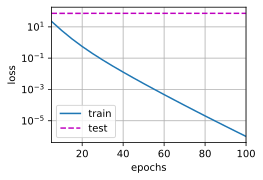

In [26]:
"""忽略正则化直接训练"""
train(lambd = 0)

w的L2范数是： 0.02798677235841751


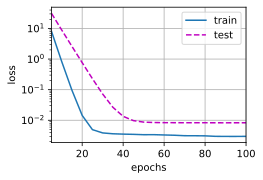

In [27]:
"""使用权重衰减"""
train(lambd = 10)

In [28]:
"""简洁实现"""
def train_concise(wd):
  net = nn.Sequential(nn.Linear(num_imputs, 1))
  for param in net.parameters():
    param.data.normal_()
  loss = nn.MSELoss()
  num_epochs , lr = 100, 0.003
  trainer = torch.optim.SGD([{"params":net[0].weight,'weight_decay':wd},
                 {"params":net[0].bias}],
                 lr=lr)
  animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
               xlim=[5, num_epochs], legend=['train', 'test'])
  for epoch in range(num_epochs):
    for X, y in train_iter:
      with torch.enable_grad():
        trainer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        trainer.step()
    if (epoch + 1) % 5 == 0:
      animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                  d2l.evaluate_loss(net, test_iter, loss)))
  print('w的L2范数是：', net[0].weight.norm().item())
      

w的L2范数是： 0.012838955037295818


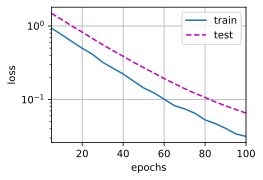

In [29]:
train_concise(100)